In [1]:
import cv2
from matplotlib import pyplot as plt

def plot_cv2(image):
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    )

plt.rcParams['figure.figsize'] = [16, 8]

## a) Proszę  wczytać przykładowy krótki film przedstawiający obraz z kamery samochodu poruszającego się po drodze i zrealizować na nim metodę wykrywania linii poprzez transformację Hough. Wynik należy zwizualizować na sekwencji wideo

In [2]:
video = cv2.VideoCapture('vid1.mov')

In [3]:
from IPython.display import HTML
HTML("""
<video width="320" height="240" controls>
  <source src="vid1.mov" type="video/mp4">
</video>
""")

In [4]:
print(video.isOpened())

True


(1920, 1080)
False


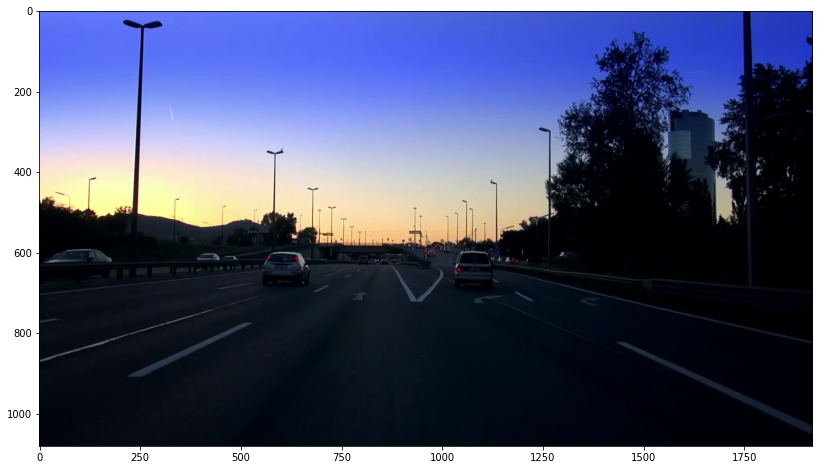

In [5]:
if video.isOpened():
    ret, frame = video.read()
    plot_cv2(frame)
video.release()
frame_shape = frame.shape[:2][::-1]
print(frame_shape)
print(video.isOpened())

In [6]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V') 
video_lines_name = 'vid1_lines.mov'
video_lines = cv2.VideoWriter(
    video_lines_name, 
    fourcc = fourcc, 
    fps = 20.0, 
    frameSize = frame_shape
)

In [7]:
import numpy as np
import math

frames = []
video = cv2.VideoCapture('vid1.mov')
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    
    frame_copy = frame.copy()
    
    frame = cv2.GaussianBlur(
        frame, 
        (3, 3), 
        0, 
    )
    
    canny = cv2.Canny(
        frame, 
        threshold1 = 60, 
        threshold2 = 200,
        apertureSize = 3
    ) 

    lines = cv2.HoughLines(
        canny, 
        rho = 1, 
        theta = np.pi / 180, 
        threshold = 220
    )

    for line in lines:
        r = line[0][0]
        phi = line[0][1]
        a = math.cos(phi)
        b = math.sin(phi)
        x0 = a * r
        y0 = b * r
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(
            frame_copy, 
            pt1 = pt1, 
            pt2 = pt2, 
            color = (0, 0, 255), 
            thickness = 1, 
            lineType = cv2.LINE_AA
        )
    frames.append(frame_copy)
video.release()

In [8]:
for frame in frames:
    video_lines.write(frame)
video_lines.release()

In [9]:
video_lines = cv2.VideoCapture(video_lines_name)
frames = []
while video_lines.isOpened():
    ret, frame = video_lines.read()
    if not ret:
        break
    frames.append(frame)
video_lines.release()

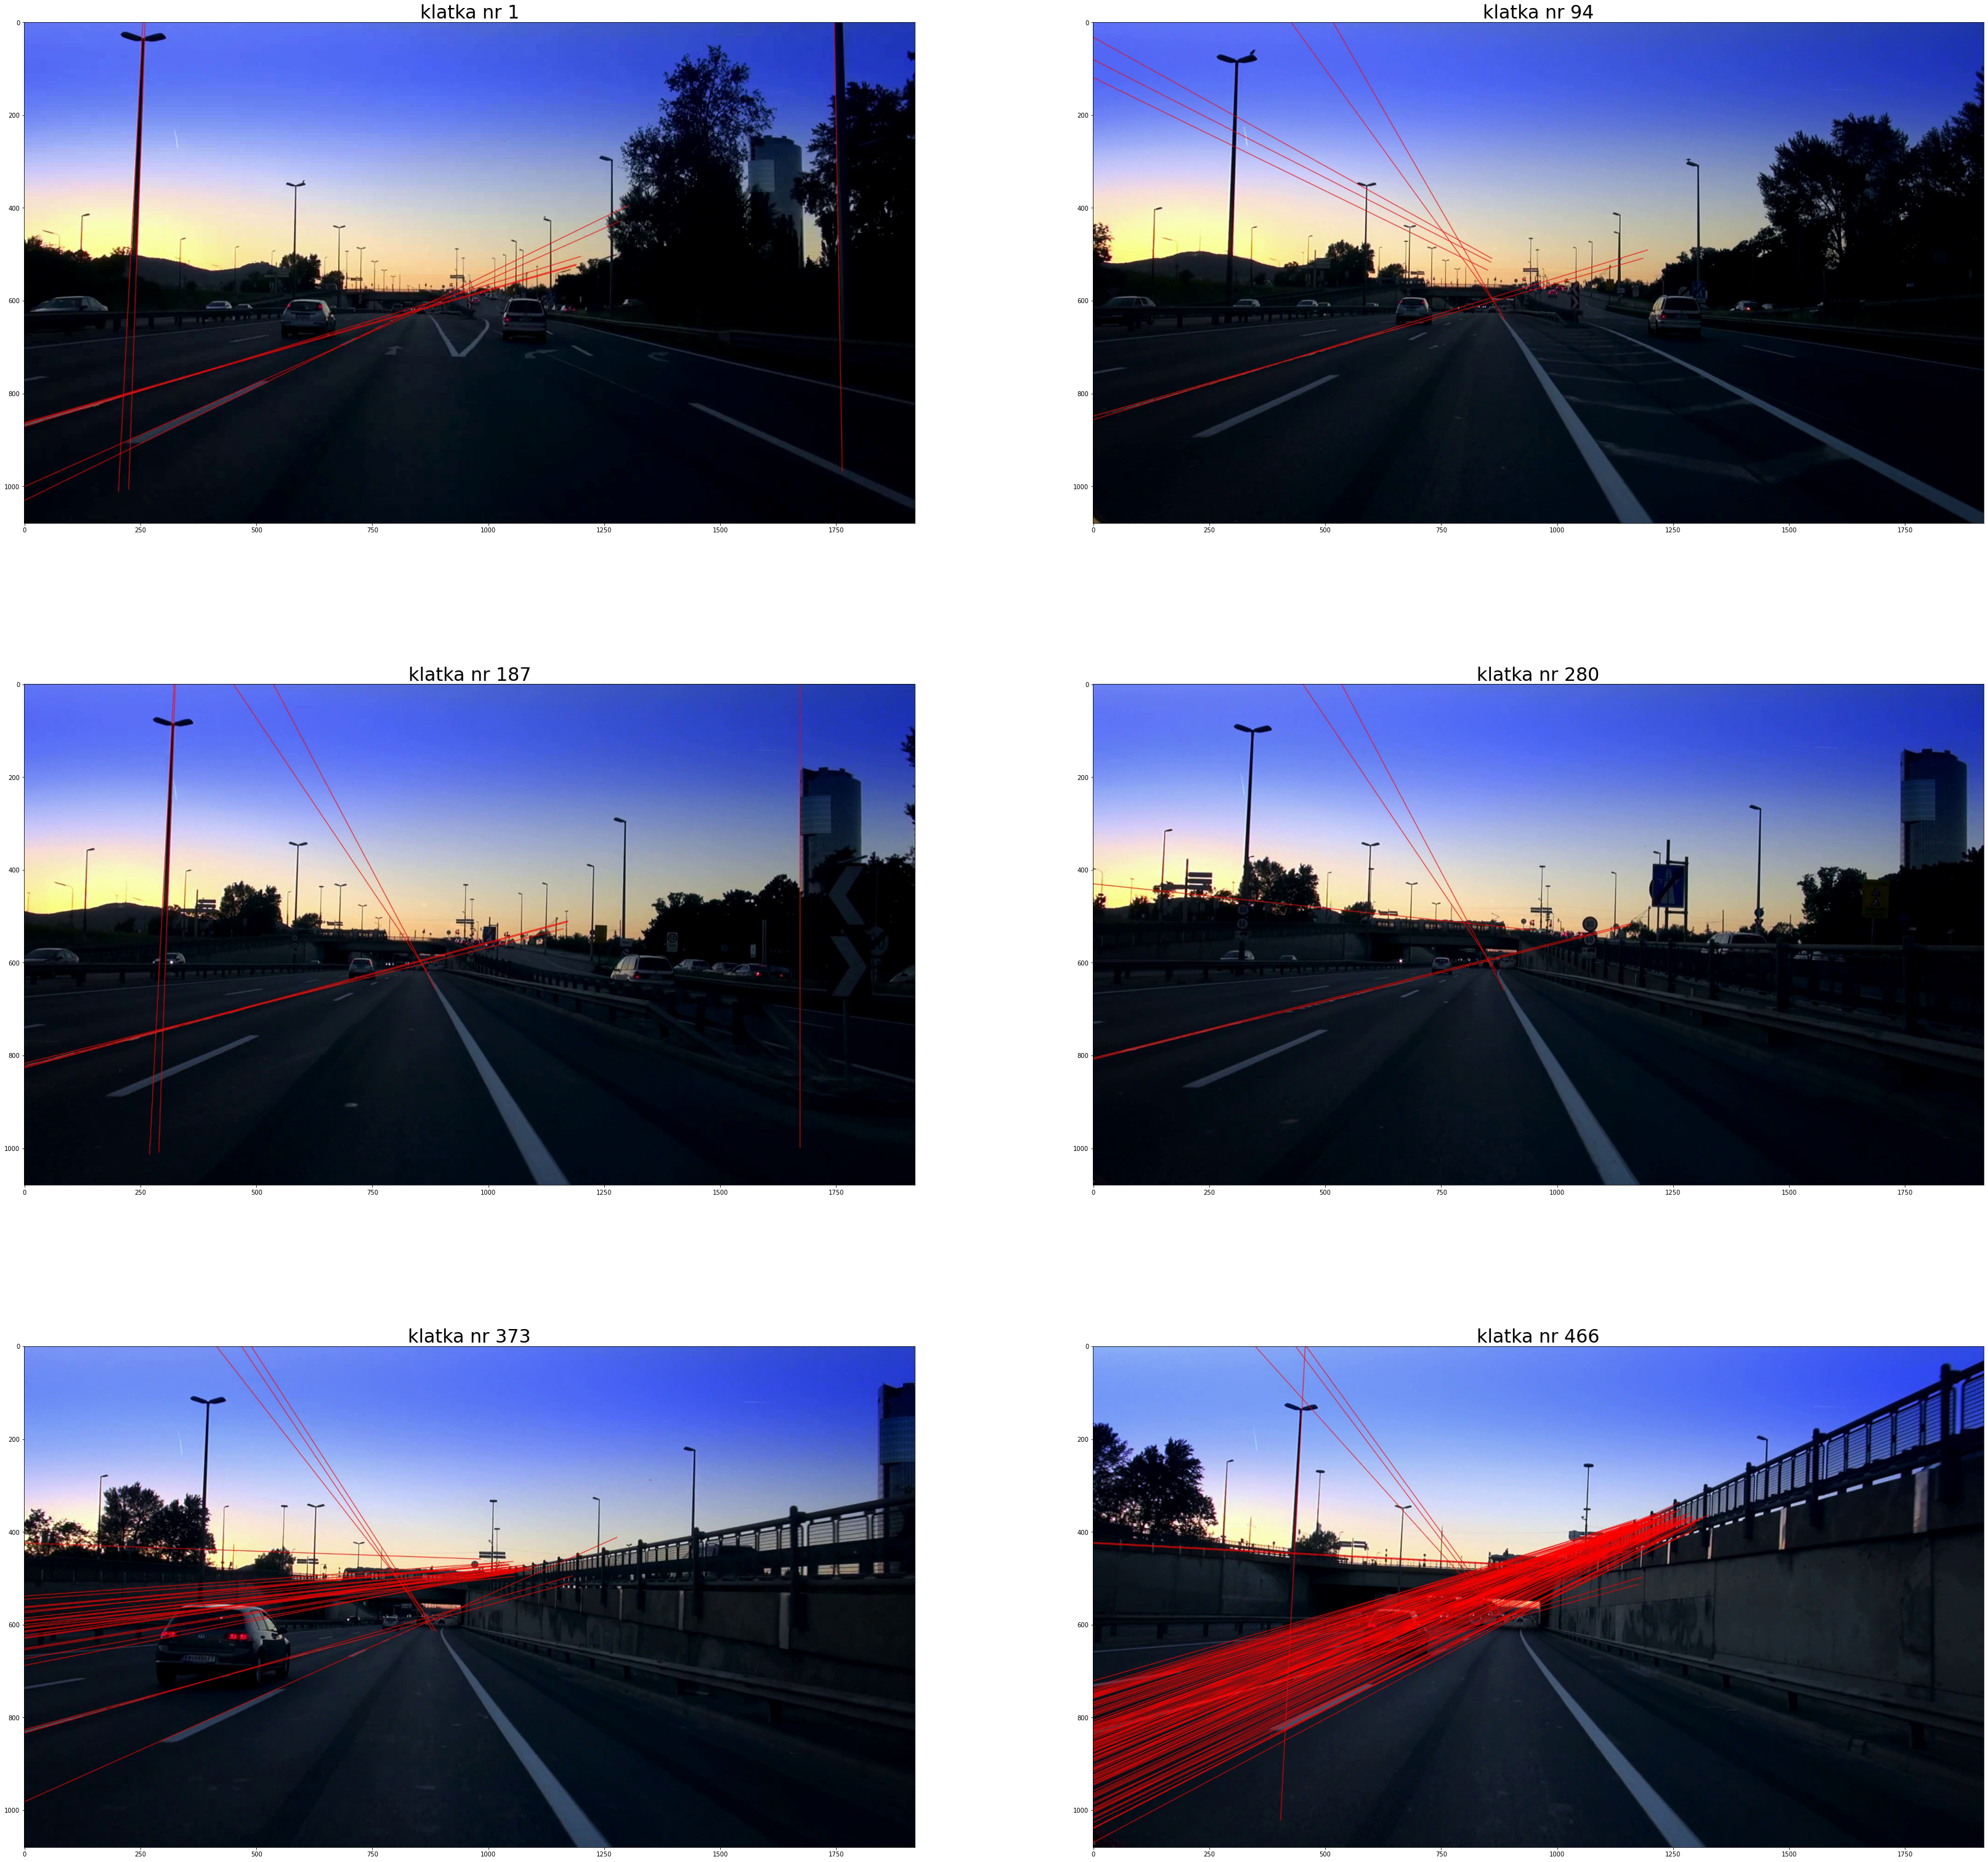

In [10]:
f = plt.figure(1, figsize=(3*19, 2*28))
_i = 1
step = len(frames)//5 - 3
for i in range(0, len(frames), step):
    ax = f.add_subplot(3, 2, _i)
    ax.set_title(f"klatka nr {i+1}", fontsize=30)
    plot_cv2(frames[i])
    _i += 1

---

## b) Wczytać drugi film, przedstawiający nagranie samochodów na autostradzie. Przenieść do odcieni szarości. Stworzyć sekwencję różnic pomiędzy kolejnymi klatkami. Utworzone różnice wykorzystać jako maski na oryginalnych klatkach. (Jeżeli klatki są za duże, to można je przeskalować)

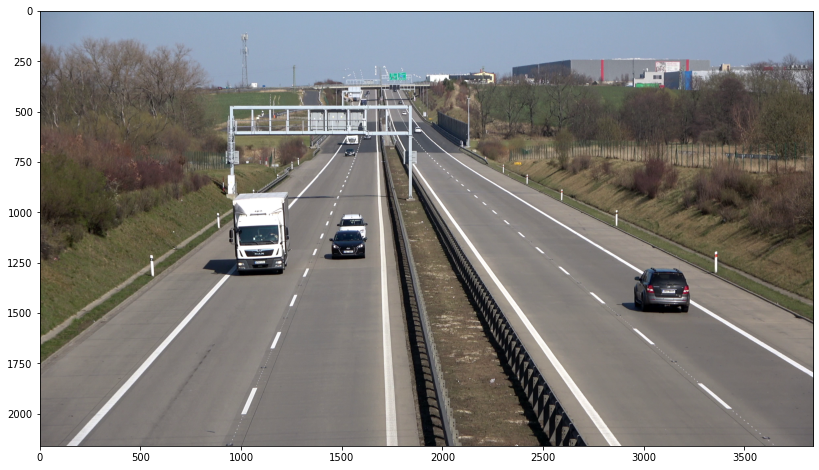

In [11]:
video = cv2.VideoCapture('vid2.mov')
if video.isOpened():
    ret, frame = video.read()
    plot_cv2(frame)
video.release()
frame_shape = frame.shape[:2][::-1]

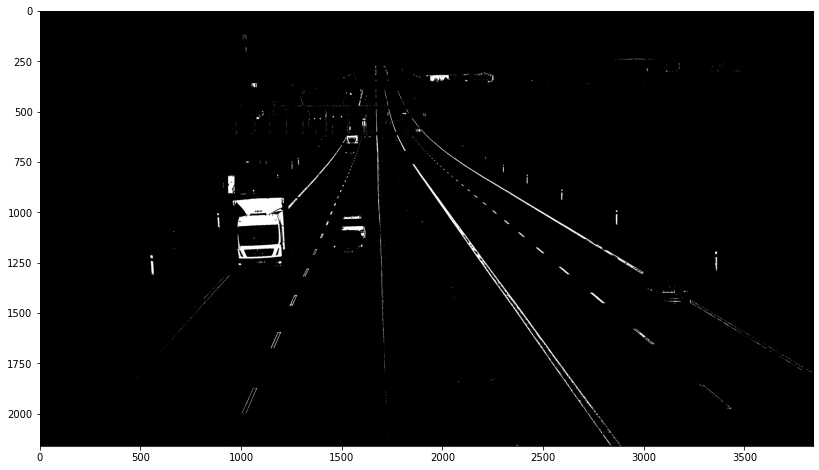

In [12]:
frames = []
diff_frames = []
threshold = 250

video = cv2.VideoCapture('vid2.mov')
i = 0
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, frame_gray = cv2.threshold(
            frame_gray,
            thresh = threshold,
            maxval = 255,
            type = cv2.THRESH_BINARY
        )
    frames.append(frame_gray)
    if i > 0:
        diff_frames.append(frames[i] - frames[i-1])
    i += 1
video.release()
plot_cv2(frames[0])

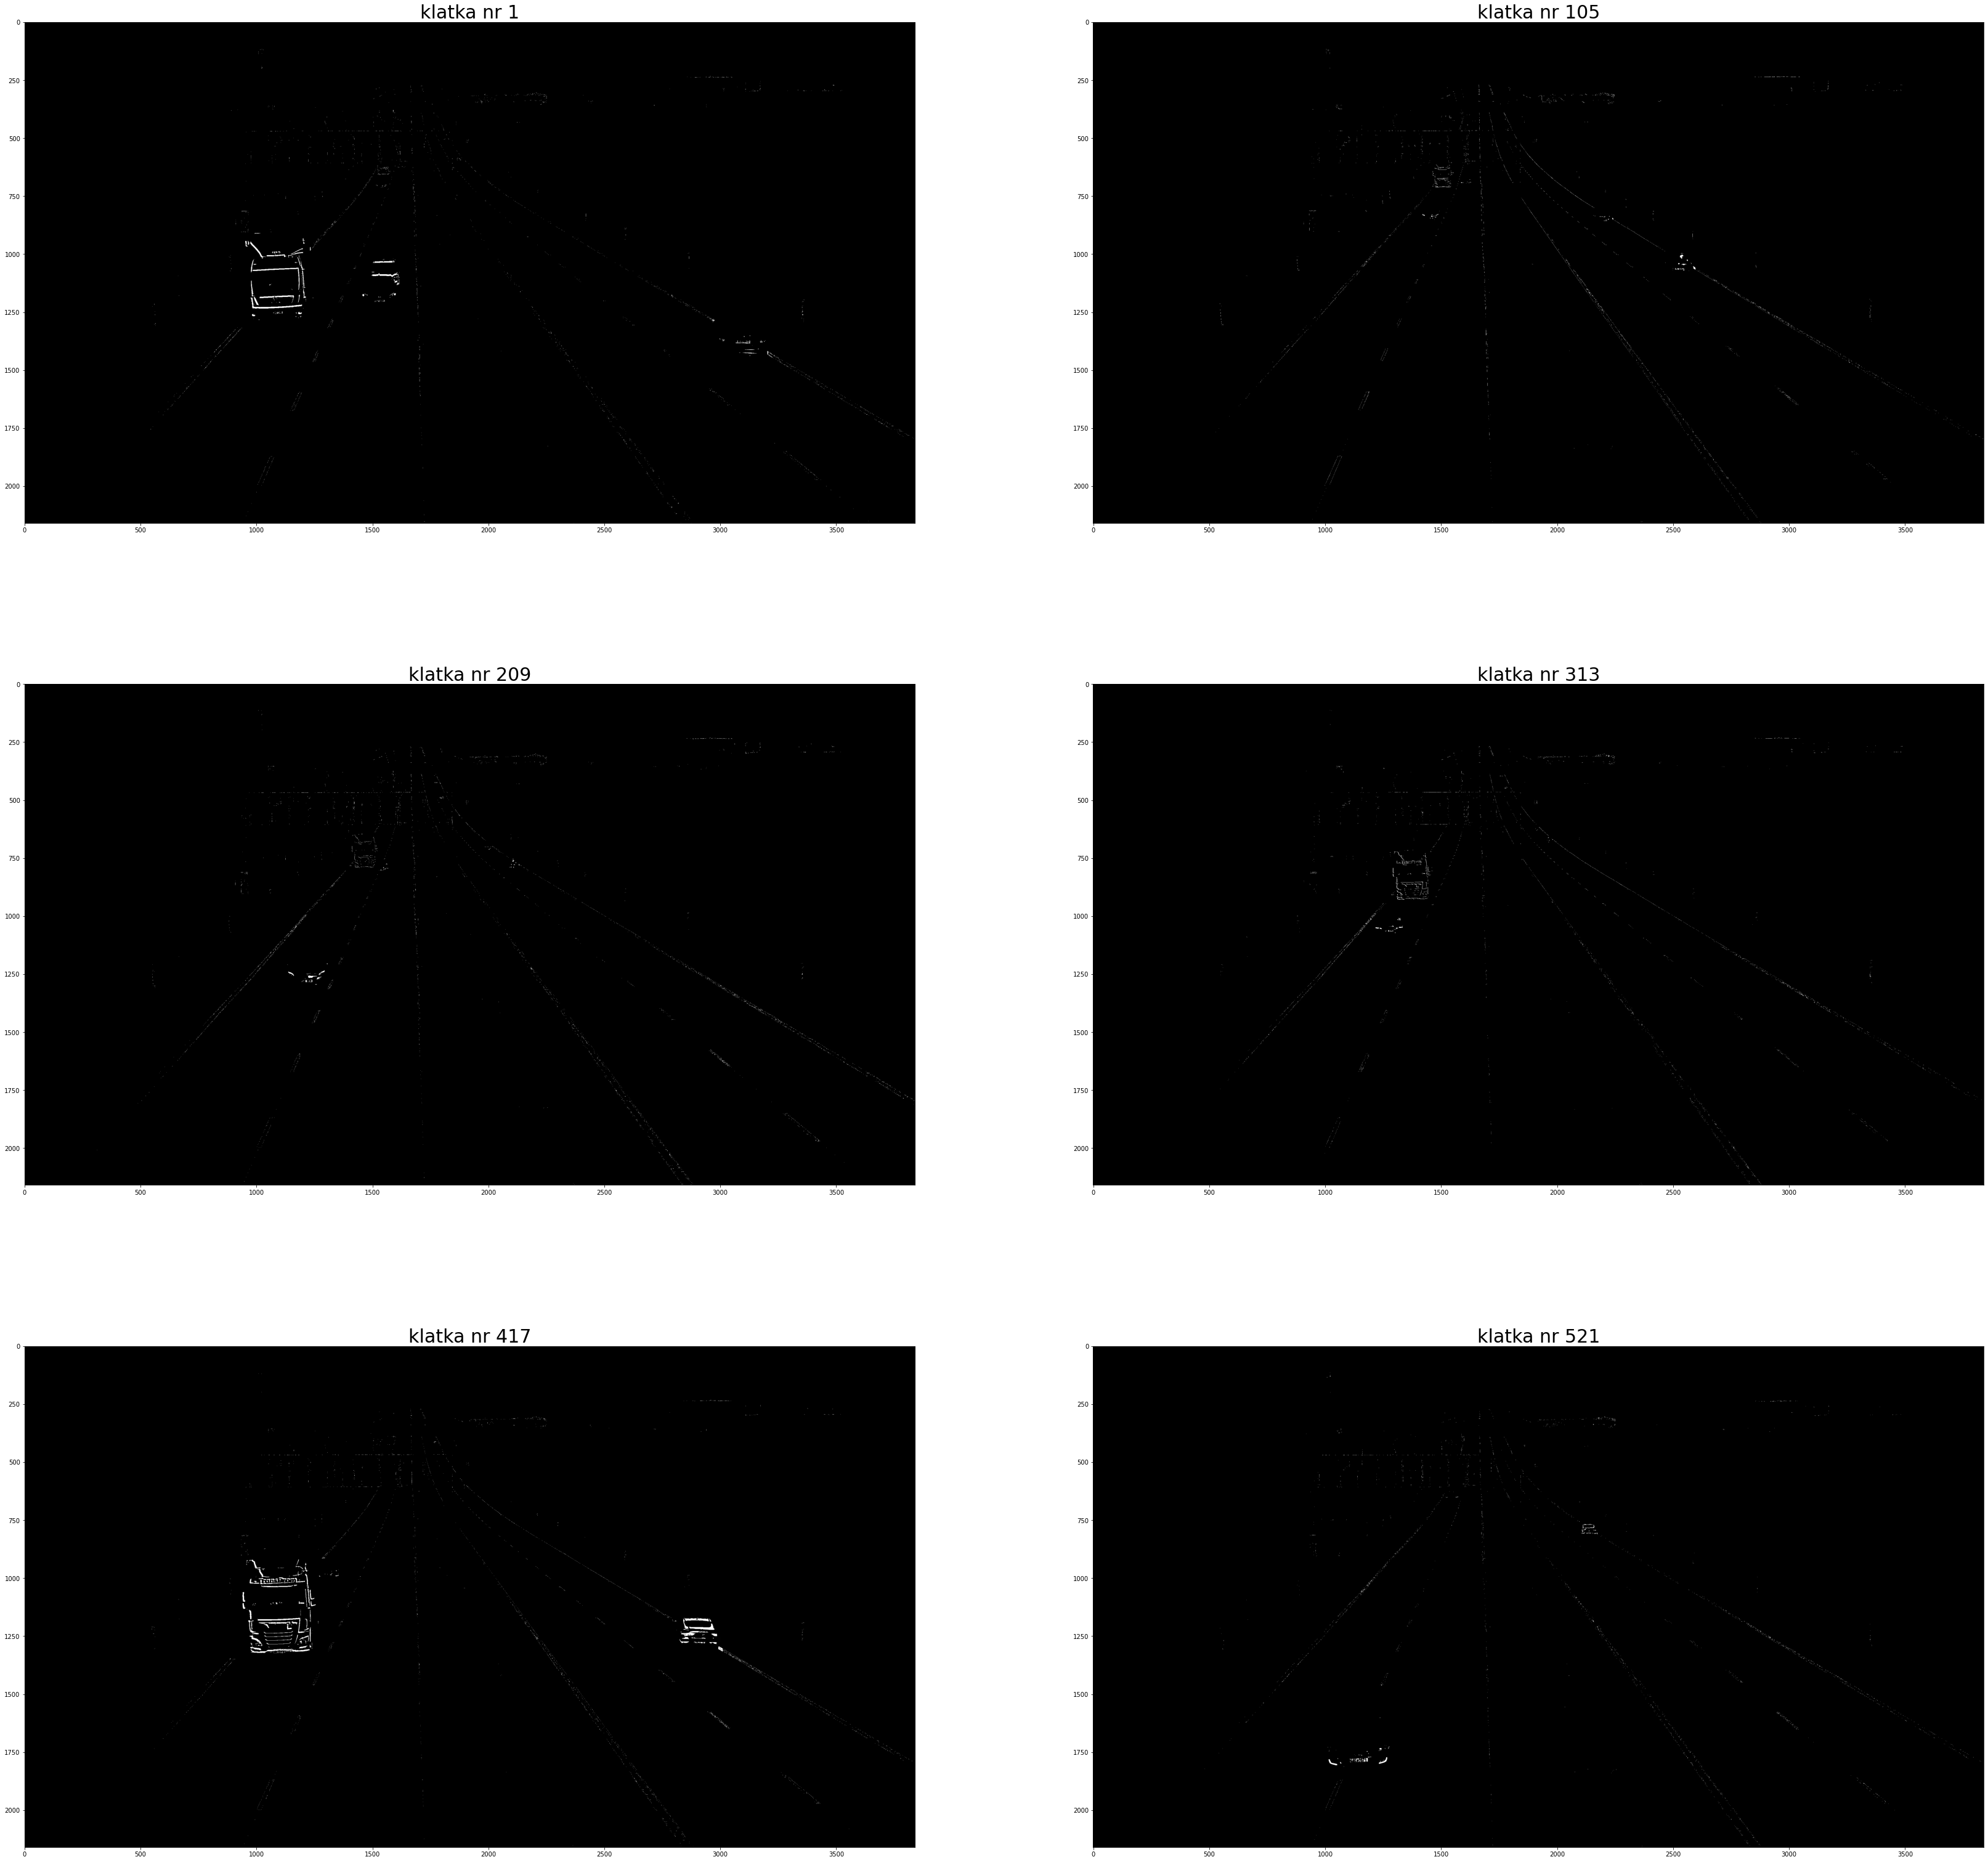

In [13]:
f = plt.figure(1, figsize=(3*19, 2*28))
_i = 1
step = len(diff_frames)//5 - 3
for i in range(0, len(diff_frames), step):
    ax = f.add_subplot(3, 2, _i)
    ax.set_title(f"klatka nr {i+1}", fontsize=30)
    plot_cv2(diff_frames[i])
    _i += 1

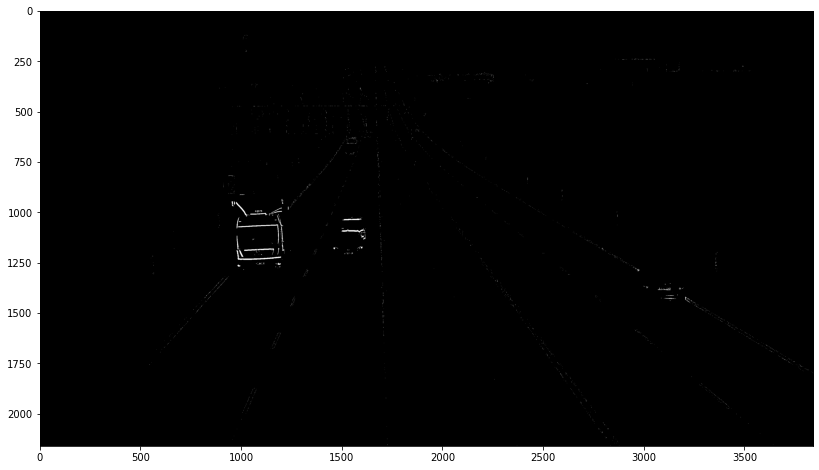

In [14]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V') 
video_diff_name = 'vid2_diff.mov'
video_diff = cv2.VideoWriter(
    video_diff_name, 
    fourcc = fourcc, 
    fps = 20.0, 
    frameSize = frame_shape,
    isColor = False
)

try:
    for i, diff_frame in enumerate(diff_frames):
        difference = cv2.bitwise_and(frames[i+1], frames[i+1], mask=diff_frame)
        _, difference = cv2.threshold(
            difference,
            thresh = threshold//2,
            maxval = 255,
            type = cv2.THRESH_BINARY
        )
        video_diff.write(difference)
        if i == 0:
            plot_cv2(difference)
except Exception as e:
    raise e
finally:
    video_diff.release()